### Spooky Author Identification
Identify author of a text using simple NLP techniques

In [2]:
import pandas as pd
import re

from typing import Any, List

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

from plots import plot_confusion_matrix_plt, plot_roc_graph, plot_precision_recall_curve

from scipy.sparse.csr import csr_matrix

### Simple EDA

In [3]:
data = pd.read_csv(r'../../data/spooky-author-identification/train.csv')
print('Data Shape: ', data.shape[0])

data.head()

Data Shape:  19579


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


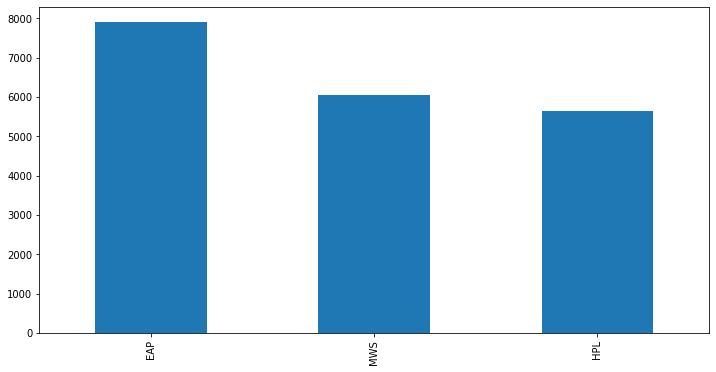

In [4]:
# class distribution
data['author'].value_counts().plot(kind='bar',figsize=(12,6));

- the distribution looks more or less okay, don't apply any class balancing
- probably on test data we will have the following distribution of correctly predicting classes: `EAP`, `MWS`, `HPL`

### Preprocessing


In [5]:
# preprocessing functions

def remove_punctuation(text: str) -> str:
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def remove_stopwords(text: str, sw: list) -> str:
    sw = set(sw)
    text = [
        word.lower() for word in text.split() if word.lower() not in sw
    ]
    return " ".join(text)


def remove_numbers(text: str):
    text = [
        re.sub(r'\d+(?:\.\d+)?', '', word) for word in text.split()
    ]
    return " ".join(text)


def stem_text(text: str, stemmer: Any) -> str:
    text = [
        stemmer.stem(word) for word in text.split()
    ]
    return " ".join(text)


def lemmatize_text(text: str, lemmatizer: Any) -> str:
    text = [
        lemmatizer.lemmatize(word) for word in text.split()
    ]
    return " ".join(text)


def get_top_words(vocab: dict, n: int = 10, ascending: bool = False) -> pd.Series:
    """
    Get N top words from word counts (words distribution).

    Parameters
    ----------
    vocab: dict
        Word counts (e.g. {'sunny': 10, 'big': 23}).
    n: int
        Number of words to show (e.g. 10 -> top 10).
    ascending: bool
        If True, show in ascending order.

    Returns
    -------
    pd.DataFrame
        Word counts.

    """
    if ascending:
        result = pd.Series(vocab).sort_values()
    else:
        result = pd.Series(vocab).sort_values(ascending=False)
    return result.iloc[:n]


def get_pd_fm(sparce_matrix: csr_matrix, vectorizer: Any) -> pd.DataFrame:
    """
    Transforms Sparse CSR matrix into Pandas dense with feature names in columns.

    Parameters
    ----------
    sparce_matrix
        Sparce matrix of features.
    vectorizer: Any
        Used vectorizer for features generation (e.g. 'CountVectorizer', ...).
    
    Returns
    -------
    pd.DataFrame
        Pandas dense matrix of features.
    """
    return pd.DataFrame(
        data=sparce_matrix.todense(),
        columns=vectorizer.vocabulary_.keys()
    )

In [13]:
def custom_preprocessor(text: str, stop_words: List[str], normalizer: Any) -> str:
    """Basic preprocessing for text."""
    # preprocessing
    clean_text = remove_punctuation(text)
    clean_text = remove_numbers(clean_text)
    clean_text = remove_stopwords(clean_text, stop_words)

    # text normalization
    if re.search(r'.*stemmer', type(normalizer).__name__,  re.IGNORECASE):
        clean_text = stem_text(clean_text, normalizer)
    
    if re.search(r'.*lemma', type(normalizer).__name__,  re.IGNORECASE):
        clean_text = lemmatize_text(clean_text, normalizer)

    return clean_text


# make a class for sklear Pipeline
class CustomPreprocessor:
    def __init__(self, stop_words, normalizer):
        self.stop_words = stop_words
        self.normalizer = normalizer


    def __call__(self, text):
        # preprocessing
        clean_text = remove_punctuation(text)
        clean_text = remove_numbers(clean_text)
        clean_text = remove_stopwords(clean_text, self.stop_words)

        # text normalization
        if re.search(r'.*stemmer', type(self.normalizer).__name__,  re.IGNORECASE):
            clean_text = stem_text(clean_text, self.normalizer)
        
        if re.search(r'.*lemma', type(self.normalizer).__name__,  re.IGNORECASE):
            clean_text = lemmatize_text(clean_text, self.normalizer)

        return clean_text

In [14]:
# preprocessing testing
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

preprocessor = CustomPreprocessor(
    stop_words=stop_words,
    normalizer=lemmatizer
)

clean_text = custom_preprocessor(
    text=data['text'].iloc[23],
    stop_words=stop_words,
    normalizer=lemmatizer
)

clean_text

'deep spirit wonder perplexity wont regard remote pew gallery step solemn slow ascended pulpit reverend man countenance demurely benign robe glossy clerically flowing wig minutely powdered rigid vast could late sour visage snuffy habiliment administered ferule hand draconian law academy'

### Train/Test Split
Split the data into train and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['author'],
    test_size=0.3,
    stratify=data['author'],
    shuffle=True,
    random_state=42
)

y_train.value_counts(), y_test.value_counts()

(EAP    5530
 MWS    4231
 HPL    3944
 Name: author, dtype: int64,
 EAP    2370
 MWS    1813
 HPL    1691
 Name: author, dtype: int64)

### Baseline Pipeline
Build a simple baseline without any complicated logic. We will use the following metrics to compare the performance:
- `f1-micro`: sensitive to overall performance on all classes
- `f1-weighted`: gives more weight to a class with more number of samples
- `roc-auc`: baseline metric. We would better use `pr-auc` but it requires additional efforts

In [16]:
# vectorizers
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
    ngram_range=(1,1),
    max_df=1,
    min_df=1,
)

count_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=(1,1),
    max_df=1,
    min_df=1,
)

# model
model = LogisticRegression()

In [17]:
# pipeline
tfidf_pipeline = Pipeline(steps=[
    ('vectorizer', tfidf_vectorizer), 
    ('classifier', model)  
])

count_vect_pipeline = Pipeline(steps=[
    ('vectorizer', count_vectorizer), 
    ('classifier', model)  
])

In [18]:
%%time

cv_results = cross_validate(
    tfidf_pipeline, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23),
    scoring=['f1_micro', 'f1_weighted', 'roc_auc_ovr_weighted'],
    error_score='raise',
    n_jobs=-1
)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 12.5 s


,test_f1_micro,test_f1_weighted,test_roc_auc_ovr_weighted
0,0.484568,0.425854,0.63076


In [27]:
%%time

cv_results = cross_validate(
    count_vect_pipeline, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23),
    scoring=['f1_micro', 'f1_weighted', 'roc_auc_ovr_weighted'],
    error_score='raise',
    n_jobs=-1
)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 3.69 s


,test_f1_micro,test_f1_weighted,test_roc_auc_ovr_weighted
0,0.486976,0.430662,0.632137


**Interpretation**
- By default `CountVectorizer` provides a bit better results

### Performance Estimation (Test Data)

In [52]:
from sklearn.metrics import f1_score, roc_auc_score

def get_test_performance(model, X_test, y_test):
    """Hardcoded model evaluation"""
    summary = pd.DataFrame()
    labels_pred = model.predict(X_test)
    proba_pred = model.predict_proba(X_test)

    summary['f1_micro'] = [f1_score(y_test, labels_pred, average='micro')]
    summary['f1_weighted'] = f1_score(y_test, labels_pred, average='weighted')
    summary['roc_auc_ovr_weighted'] = roc_auc_score(y_test, proba_pred, multi_class='ovr', average='weighted')
    return summary

In [10]:
tfidf_pipeline.fit(X_train, y_train)
count_vect_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=1,
                                 preprocessor=<__main__.CustomPreprocessor object at 0x000001FCE91142C8>)),
                ('classifier', LogisticRegression())])

In [54]:
count_vect_predictions = count_vect_pipeline.predict(X_test)
tfidf_predictions = tfidf_pipeline.predict(X_test)

count_vect_pred_proba = count_vect_pipeline.predict_proba(X_test)
tfidf_pred_proba = tfidf_pipeline.predict_proba(X_test)

In [58]:
# test performance evaluation
count_vec_test = get_test_performance(count_vect_pipeline, X_test, y_test)
tfidf_test = get_test_performance(tfidf_pipeline, X_test, y_test)

In [59]:
count_vec_test, tfidf_test

(   f1_micro  f1_weighted  roc_auc_ovr_weighted
 0  0.480082     0.412517              0.621448,
    f1_micro  f1_weighted  roc_auc_ovr_weighted
 0  0.480422     0.411383              0.620934)

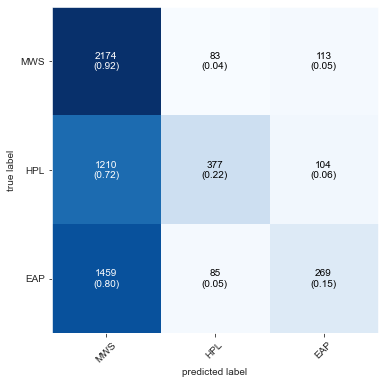

In [60]:
count_vect_cm_test = plot_confusion_matrix_plt(
    true_labels=y_test,
    pred_labels=count_vect_predictions,
    problem='multiclass',
    class_names=set(y_test),
    figsize=(6,6),
    return_figure=True
)

- Model has issues with `MWS` and `HPL` classes
- CM using `CountVectorizer` looks similar

In [61]:
y_train.value_counts()

EAP    5530
MWS    4231
HPL    3944
Name: author, dtype: int64

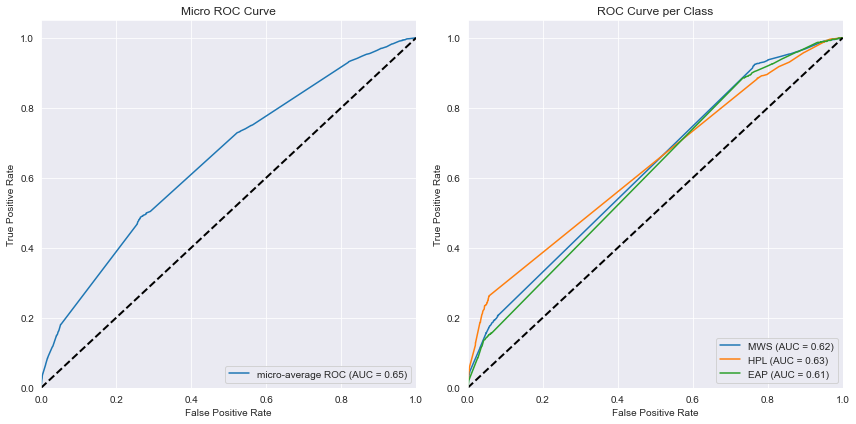

In [62]:
count_roc_auc_test = plot_roc_graph(
    true_labels=y_test,
    pred_proba=count_vect_pred_proba,
    problem='multiclass',
    average_type='micro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

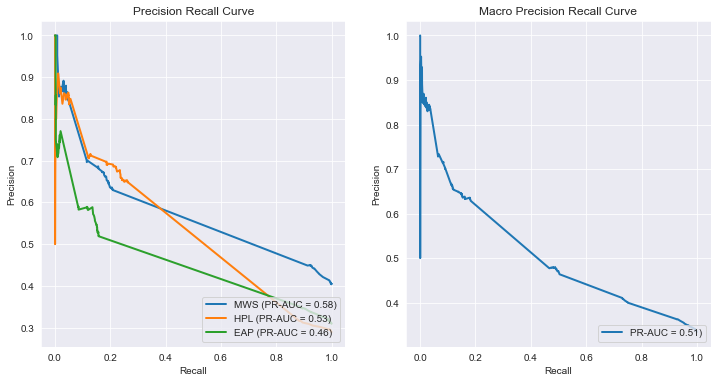

In [63]:
count_pr_curve_test = plot_precision_recall_curve(
    true_labels=y_test,
    pred_proba=count_vect_pred_proba,
    problem='multiclass',
    average_type='macro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

### Baseline Improvement
Let's try to improve baseline by tweaking some parameters of Vectorizers:
- `ngram_range`
- `max_df` and `min_df`

In [64]:
# vectorizers
max_df = 0.8
min_df = 1
ngram_range = (1,1)
max_features = 20_000

tfidf_vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
    ngram_range=ngram_range,
    max_features=max_features,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_df=max_df,
    min_df=min_df,
)

count_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=ngram_range,
    max_features=max_features,
    max_df=max_df,
    min_df=min_df,
)

# model
model_params = {
    'penalty': "l2",
    'C': 3,
    'class_weight': "balanced",
    'random_state': 23,
    'multi_class': "auto",
    'n_jobs': -1,
}

model = LogisticRegression(**model_params)

# pipeline
tfidf_pipeline = Pipeline(steps=[
    ('vectorizer', tfidf_vectorizer), 
    ('classifier', model)  
])

count_vect_pipeline = Pipeline(steps=[
    ('vectorizer', count_vectorizer), 
    ('classifier', model)  
])

In [65]:
%%time

cv_results = cross_validate(
    tfidf_pipeline, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23),
    scoring=['f1_micro', 'f1_weighted', 'balanced_accuracy'],
    error_score='raise',
    n_jobs=-1
)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 11.8 s


,test_f1_micro,test_f1_weighted,test_balanced_accuracy
0,0.805983,0.805975,0.805827


In [66]:
%%time

cv_results = cross_validate(
    count_vect_pipeline, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23),
    scoring=['f1_micro', 'f1_weighted', 'balanced_accuracy'],
    error_score='raise',
    n_jobs=1
)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 18.1 s


,test_f1_micro,test_f1_weighted,test_balanced_accuracy
0,0.786136,0.786046,0.783454


### Performance Estimation (Test Data)

In [67]:
tfidf_pipeline.fit(X_train, y_train)
count_vect_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, max_features=20000,
                                 preprocessor=<__main__.CustomPreprocessor object at 0x000001C2E1EB8988>)),
                ('classifier',
                 LogisticRegression(C=3, class_weight='balanced', n_jobs=-1,
                                    random_state=23))])

In [68]:
count_vect_predictions = count_vect_pipeline.predict(X_test)
tfidf_predictions = tfidf_pipeline.predict(X_test)

count_vect_pred_proba = count_vect_pipeline.predict_proba(X_test)
tfidf_pred_proba = tfidf_pipeline.predict_proba(X_test)

In [69]:
# test performance evaluation
count_vec_test = get_test_performance(count_vect_pipeline, X_test, y_test)
tfidf_test = get_test_performance(tfidf_pipeline, X_test, y_test)

In [70]:
count_vec_test, tfidf_test

(   f1_micro  f1_weighted  roc_auc_ovr_weighted
 0   0.78873     0.788601              0.926346,
    f1_micro  f1_weighted  roc_auc_ovr_weighted
 0  0.702417     0.688931              0.919927)

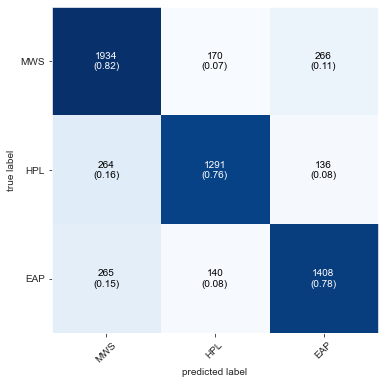

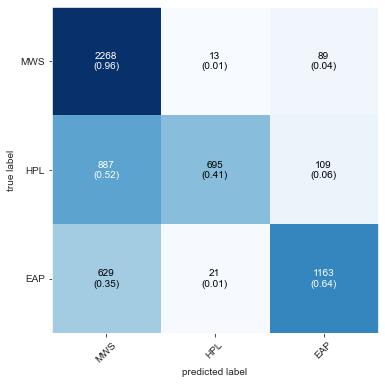

In [71]:
count_vect_cm_test = plot_confusion_matrix_plt(
    true_labels=y_test,
    pred_labels=count_vect_predictions,
    problem='multiclass',
    class_names=set(y_test),
    figsize=(6,6),
    return_figure=True
)

tfidf_cm_test = plot_confusion_matrix_plt(
    true_labels=y_test,
    pred_labels=tfidf_predictions,
    problem='multiclass',
    class_names=set(y_test),
    figsize=(6,6),
    return_figure=True
)

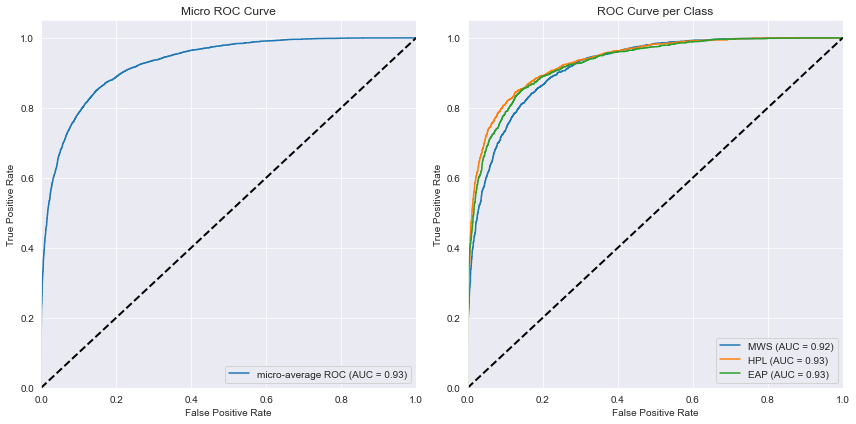

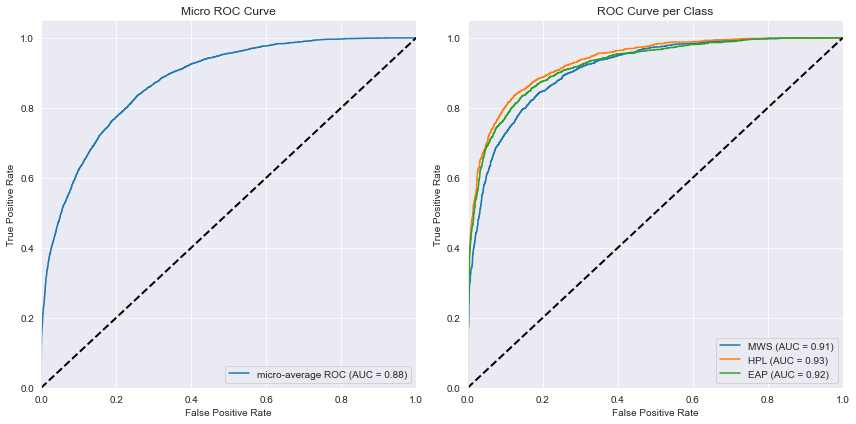

In [72]:
count_roc_auc_test = plot_roc_graph(
    true_labels=y_test,
    pred_proba=count_vect_pred_proba,
    problem='multiclass',
    average_type='micro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

tfidf_roc_auc_test = plot_roc_graph(
    true_labels=y_test,
    pred_proba=tfidf_pred_proba,
    problem='multiclass',
    average_type='micro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

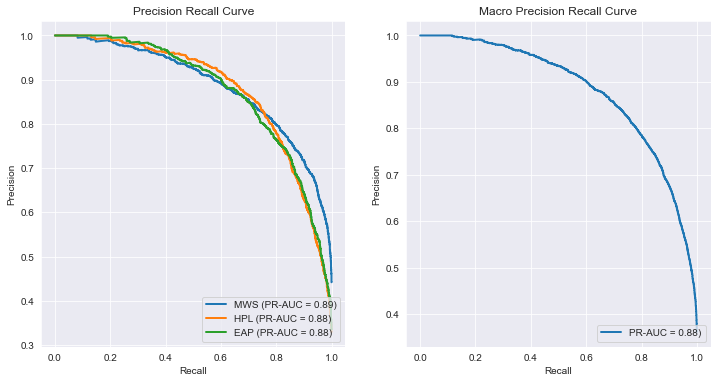

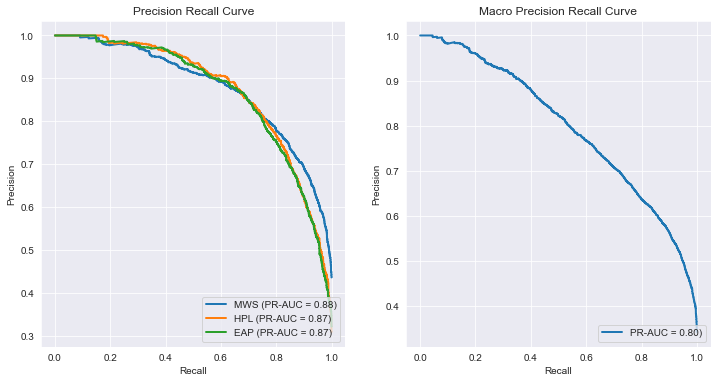

In [73]:
count_pr_curve_test = plot_precision_recall_curve(
    true_labels=y_test,
    pred_proba=count_vect_pred_proba,
    problem='multiclass',
    average_type='macro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

tfidf_pr_curve_test = plot_precision_recall_curve(
    true_labels=y_test,
    pred_proba=tfidf_pred_proba,
    problem='multiclass',
    average_type='macro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)


- Looks like `CountVectorizer` demonstrated much better performance though the CV performance was lower in comparison with `TFIDF` (probably overfitting)

### RandomForest Experiment
Let's check if RandomForest improve the final quality

In [94]:
# vectorizers
max_df = 0.8
min_df = 1
ngram_range = (1,1)
max_features = 20_000

tfidf_vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
    ngram_range=ngram_range,
    max_features=max_features,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_df=max_df,
    min_df=min_df,
)

count_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=ngram_range,
    max_features=max_features,
    max_df=max_df,
    min_df=min_df,
)

# model
model = RandomForestClassifier(
    n_estimators=50, 
    criterion='gini', 
    max_depth=None,
    min_samples_split=6,
    min_samples_leaf=2,  
    max_features=2,
    random_state=23,
    n_jobs=-1,   
    ccp_alpha=0.0,
    class_weight={'MWS':1, 'HPL': 5, 'EAP': 10}
)

# pipeline
tfidf_pipeline = Pipeline(steps=[
    ('vectorizer', tfidf_vectorizer), 
    ('classifier', model)  
])

count_vect_pipeline = Pipeline(steps=[
    ('vectorizer', count_vectorizer), 
    ('classifier', model)  
])

In [95]:
%%time

cv_results = cross_validate(
    tfidf_pipeline, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23),
    scoring=['f1_micro', 'f1_weighted', 'balanced_accuracy'],
    error_score='raise',
    n_jobs=-1
)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 5.31 s


,test_f1_micro,test_f1_weighted,test_balanced_accuracy
0,0.403502,0.232011,0.333333


In [96]:
%%time

cv_results = cross_validate(
    count_vect_pipeline, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23),
    scoring=['f1_micro', 'f1_weighted', 'balanced_accuracy'],
    error_score='raise',
    n_jobs=1
)

pd.DataFrame(pd.DataFrame(cv_results).mean()).iloc[2:, :].T

Wall time: 8.49 s


,test_f1_micro,test_f1_weighted,test_balanced_accuracy
0,0.403502,0.232011,0.333333


In [97]:
tfidf_pipeline.fit(X_train, y_train)
count_vect_pipeline.fit(X_train, y_train)

count_vect_predictions = count_vect_pipeline.predict(X_test)
tfidf_predictions = tfidf_pipeline.predict(X_test)

count_vect_pred_proba = count_vect_pipeline.predict_proba(X_test)
tfidf_pred_proba = tfidf_pipeline.predict_proba(X_test)

# test performance evaluation
count_vec_test = get_test_performance(count_vect_pipeline, X_test, y_test)
tfidf_test = get_test_performance(tfidf_pipeline, X_test, y_test)

In [98]:
count_vec_test, tfidf_test

(   f1_micro  f1_weighted  roc_auc_ovr_weighted
 0  0.403473     0.231982              0.549401,
    f1_micro  f1_weighted  roc_auc_ovr_weighted
 0  0.403473     0.231982              0.501992)

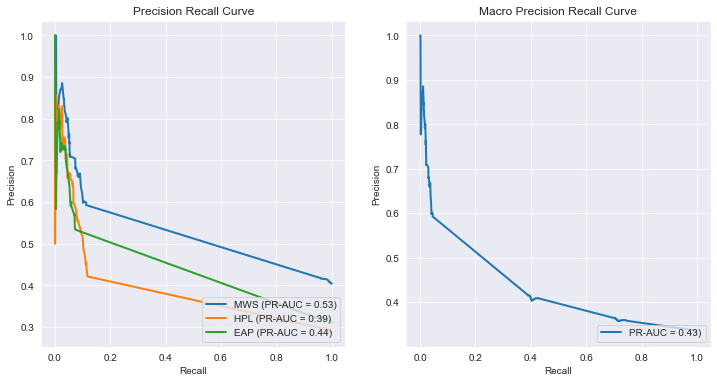

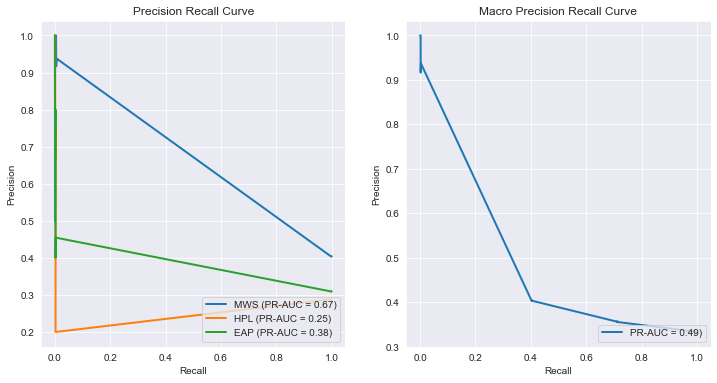

In [92]:
count_pr_curve_test = plot_precision_recall_curve(
    true_labels=y_test,
    pred_proba=count_vect_pred_proba,
    problem='multiclass',
    average_type='macro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

tfidf_pr_curve_test = plot_precision_recall_curve(
    true_labels=y_test,
    pred_proba=tfidf_pred_proba,
    problem='multiclass',
    average_type='macro',
    class_names=list(set(y_test)),
    figsize=(12,6),
    sns_style='darkgrid',
    return_figure=True
)

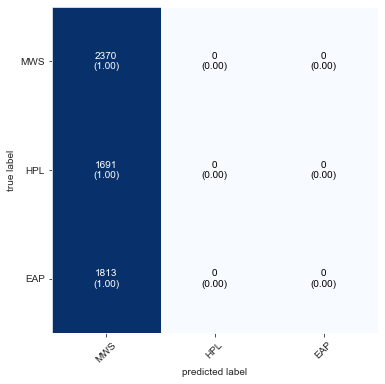

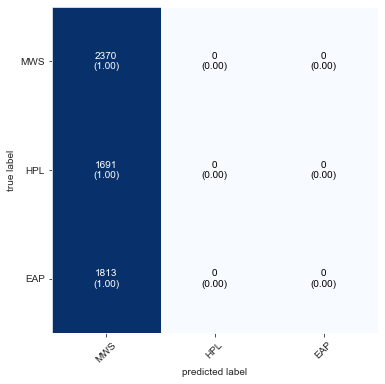

In [93]:

count_vect_cm_test = plot_confusion_matrix_plt(
    true_labels=y_test,
    pred_labels=count_vect_predictions,
    problem='multiclass',
    class_names=set(y_test),
    figsize=(6,6),
    return_figure=True
)

tfidf_cm_test = plot_confusion_matrix_plt(
    true_labels=y_test,
    pred_labels=tfidf_predictions,
    problem='multiclass',
    class_names=set(y_test),
    figsize=(6,6),
    return_figure=True
)

### Results Summary
- Baseline (Test) -> Poor Performance
    - `CountVectorizer` + `LR` (default params):
        - `f1_micro`: 0.4800
        - `f1_weighted`: 0.4125
        - `roc_auc_ovr_weighted`: 0.6214
    - `TFIDFVectorizer` + `LR` (default params):
        - `f1_micro`: 0.4804
        - `f1_weighted`: 0.4113
        - `roc_auc_ovr_weighted`: 0.6209

- 1st Baseline Improvent -> Drastic Improvement
    - `CountVectorizer` + `LR` (tuned):
        - `f1_micro`:  0.7887
        - `f1_weighted`:  0.7886
        - `roc_auc_ovr_weighted`:  0.9263
    - `TFIDFVectorizer` + `LR` (tuned):
        - `f1_micro`: 0.7024
        - `f1_weighted`:  0.6889
        - `roc_auc_ovr_weighted`: 0.9199


- 2d Baseline Improvent -> No Drastic Improvement with `RandomForest`
    - Requires more tuning of the parameters!